In [48]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 2a)

Computing the solution to the equation
$$\beta b^3 \frac{db}{dz} = \alpha b^3 - Q$$
which represents the steady state of the equations handled in part 1.

A Forward Euler method is used for the discretisation.

In [49]:
# Functions to solve the equation

# Calculating the b value at z given knowledge of the value at z - dz.
def steady_iteration(Q: float, alpha: float, beta: float, bPrev: float, 
                     dz: float) -> float:
    b = bPrev + dz * (alpha * bPrev**3 - Q) / (beta * bPrev**3)
    return b

# Solves the steady state equation for the range of z from 0 to H
def solve_steady(alpha: float, beta: float, Q: float, H: float, 
                 J: int, b0: float) -> pd.DataFrame:
    """
    Solving the steady state equation using a forward euler method.
    Parameters:
    ----------
    alpha : float
        Parameter alpha in the equation.
    beta : float
        Parameter beta in the equation.
    Q : float
        Parameter Q in the equation.
    H : float
        The height of the domain.
    J : int
        The number of steps in the z direction.
    b0 : float
        The boundary condition at z = 0.
    Returns:
    -------
    pd.DataFrame
        A dataframe with two columns: z and b, where z is the position
        in the domain and b is the corresponding value of b at that position.
    """

    # Initialize the array to store the values of b at each step
    b_values = [b0]
    dz = H / J

    # Iteratively apply the update scheme to compute b at each step
    for j in range(1, J + 1):
        b_next = steady_iteration(Q, alpha, beta, b_values[-1], dz)
        b_values.append(b_next)

    # Create a 2 column table of z againsst b values 
    z_values = [j * dz for j in range(J + 1)]
    result: list[tuple[float, float]] = list(zip(z_values, b_values))
    df = pd.DataFrame(result, columns=["z", "b"])

    return df

In [50]:
# Defining Parameters

Q = 0.99
alpha = 0.4709
beta = 1 
H = 1
bB = 1.178164343

In [51]:
# Solving the steady state equation for the given parameters
steady_solution: pd.DataFrame = solve_steady(alpha, beta, Q, H, 10001, bB)

In [52]:
steady_solution

,z,b
0,0.0000,1.178164
1,0.0001,1.178151
2,0.0002,1.178137
3,0.0003,1.178124
4,0.0004,1.178111
...,...,...
9997,0.9996,0.583931
9998,0.9997,0.583481
9999,0.9998,0.583030
10000,0.9999,0.582578


In [53]:
def dimension_plot(figure: plt.Figure, axis: plt.Axes, df: pd.DataFrame, 
                   label_width: str, label_height: str, title: str):
    # Calculate width/2 and -width/2 arrays
    width_half = df[label_width] / 2
    print(width_half)
    neg_width_half = -df[label_width] / 2

    axis.plot(width_half, df[label_height], color='blue')
    axis.plot(neg_width_half, df[label_height], color='blue')
    axis.set_xlabel(label_width)
    axis.set_ylabel(label_height)
    axis.legend()
    figure.tight_layout()
    axis.set_title(title)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0        0.589082
1        0.589075
2        0.589069
3        0.589062
4        0.589055
           ...   
9997     0.291966
9998     0.291741
9999     0.291515
10000    0.291289
10001    0.291062
Name: b, Length: 10002, dtype: float64


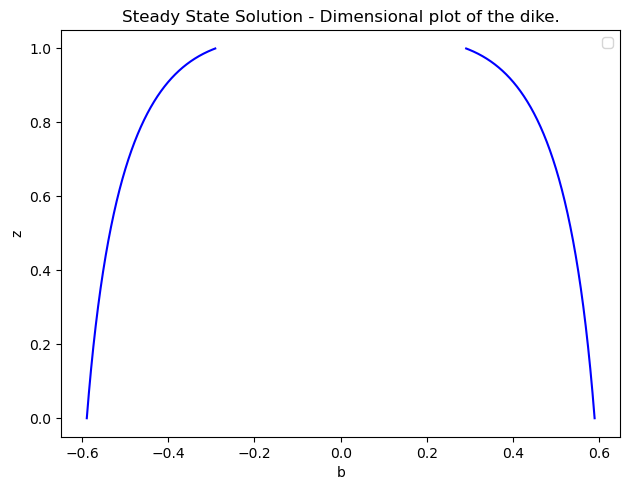

Value at z = 0:  1.178164343
Value at z = H:  0.5821240489732519


In [ ]:
# Plot the dimension plot of the steady solution#
fig, ax = plt.subplots()
dimension_plot(fig, ax, steady_solution, "b", "z", "Steady State Solution - Dimensional plot of the dike.")


### 2b)

Using the numerical scheme from part 1 to find a numerical solution to
$$\frac{\partial b}{\partial t} + \frac{\partial}{\partial x}(\alpha b^3 - \beta b^3 \frac{\partial b}{\partial x}) = 0$$

for a variety of grid sizes.

We solve using the linearised scheme where $D_0 := b_T$ and as such $b = b' + D_0$. We would assume that perturbation $b' << D_0$ however this does not hold in this case.


In [55]:
# IGNORE: Functions for solving the time-dependent scheme

# One iteration of the time dependent scheme
def linearised_time_d_iteration(bPrev: list[float], alpha: float, b0: float, 
                     beta: float, dz: float, dt: float):
    # Note that bPrev is the points from the previous time step at j-1, j and j+1 where we are 
    # calculating for the current time step at position j
    bNext: float = bPrev[1] - dt * (3 * alpha * b0 ** 2 * (bPrev[1] - bPrev[0]) / dz 
                             - beta * b0 ** 3 * (bPrev[2] - 2 * bPrev[1] + bPrev[0]) / dz**2)
    return bNext

def linear_solve_time_dependent(alpha: float, beta: float, H: float, 
                         b0: float, bT: float, J: int, dt: float, max_time: float = 2.5):
    # Solving the time dependent problem considering perturbations from a constant start
    # value bT at t = 0 with boundary conditions b(0, t) = b0 and b(H, t) = bT.
    # Note the possibility of discontinuity at z = 0 at t = 0.
    # Note also that the b_values array is initially translated to take into account that
    # we are solving for perturbations from bT, i.e. b = b' + bT where b' is the solution
    # we are calculating.

    # Initialize arrays
    dz: float = H / J
    print(f'dz: {dz}')

    # Calculate the upper bound on dt for stability
    time_step_limit(alpha, beta, b0, dt, dz)

    z_values: list[float] = [j * dz for j in range(J + 1)]
    b_values: list[list[float]] = [[0 for _ in range(J + 1)]]  # Initial condition: b(z, 0) = b0 for all z, t in the first index, z in the second index

    time_steps = int(max_time / dt)
    print(f'Time steps: {time_steps}')
    for time_step in range(time_steps):
        # Initialize the next time step array with boundary condition
        b_next: list[float] = [b0 - bT] + [0.0 for _ in range(1, J)] + [0]
        for j in range(1, J):
            b_next[j] = linearised_time_d_iteration(b_values[-1][j-1:j+2], alpha, b0, beta, dz, dt)
        b_values.append(b_next)

    time_values: list[float] = [n * dt for n in range(len(b_values))]

    # Adjust all the b_values back up by bT
    for n in range(len(b_values)):
        for j in range(len(b_values[n])):
            b_values[n][j] += bT
        
    return z_values, time_values, b_values

def time_step_limit(alpha, beta, b0, dt, dz):
    dt_stable: float = dz**2 / (3 * dz * alpha * b0**2 + 2 * beta * b0 ** 3)
    print(f"Stable dt: {dt_stable}, Given dt: {dt}")

### Non-linearized Numerical Scheme

For the full non-linear equation, the numerical iteration scheme is:

$$b_j^{n+1} = b_j^n - \Delta t \left[ \frac{\alpha}{\Delta z}((b_j^{n})^3 - (b_{j-1}^{n})^3) - \frac{\beta}{8\Delta z^2}\left((b_{j+1}^n + b_j^n)^3(b_{j+1}^n - b_j^n) - (b_j^n + b_{j-1}^n)^3(b_j^n - b_{j-1}^n)\right) \right]$$

where:
- $b_j^n$ represents the solution at position $j$ and time step $n$
- The first term handles the advection part $\alpha b^3$
- The second term handles the diffusion part $\beta b^3 \frac{\partial b}{\partial x}$ using a central difference approximation

In [56]:
# Functions for calculating the numerical scheme with the non-linearised 
# equations

def time_iteration(bPrev: list[float], alpha: float, b0: float, 
                     beta: float, dz: float, dt: float, verbosity = 0):
    # Note that bPrev is the points from the previous time step at j-1, j and j+1 where we are 
    # calculating for the current time step at position j

    convection = (alpha / dz) * (bPrev[1] ** 3 - bPrev[0] ** 3)
    diffusion = beta * ((bPrev[2] + bPrev[1]) ** 3 
                        * (bPrev[2] - bPrev[1]) 
                        - (bPrev[1] + bPrev[0]) ** 3 
                        * (bPrev[1] - bPrev[0])) / (8 * dz ** 2)
    if verbosity > 0:
        print(f'Convection: {convection}, Diffusion: {diffusion}, dt: {dt}, bPrev: {bPrev}')
    bNext: float = bPrev[1] - dt * (convection - diffusion)
    
    return bNext

def time_iteration_alternate(bPrev: list[float], alpha: float, b0: float, 
                     beta: float, dz: float, dt: float, verbosity = 1):
    # Using an alternate form for the numerical scheme

    convection = (alpha / dz) * 3 * bPrev[1]**2 * (bPrev[1] - bPrev[0])
    diffusion = (beta / (dz ** 2)) * (((bPrev[2] **3 + bPrev[1]**3) /2) * (bPrev[2] - bPrev[1]) 
    - ((bPrev[1]**3 + bPrev[0]**3)/2) * (bPrev[1] - bPrev[0]))

    bNext: float = bPrev[1] - dt * (convection - diffusion)
    return bNext

def nonlinear_solve_time_dependent(alpha: float, beta: float, H: float, 
                         b0: float, bT: float, J: int, dt: float, max_time: float = 3, 
                         initial: list[float] = None, verbosity = 0):
    # Solving the time dependent problem considering perturbations from a constant start
    # value bT at t = 0 with boundary conditions b(0, t) = b0 and b(H, t) = bT.
    # Note the possibility of discontinuity at z = 0 at t = 0.

    # Initialize arrays
    dz: float = H / J
    print(f'dz: {dz}')

    # Calculate the upper bound on dt for stability
    time_step_limit(alpha, beta, b0, dt, dz)

    z_values: list[float] = [j * dz for j in range(J + 1)]
    b_values: list[list[float]] = [[bT for _ in range(J + 1)]]  # Initial condition: b(z, 0) = b0 for all z, t in the first index, z in the second index
    if initial is not None:
        b_values[0] = initial

    time_steps = int(max_time / dt)
    print(f'Time steps: {time_steps}')
    for time_step in range(time_steps):
        # Initialize the next time step array with boundary condition
        b_next: list[float] = [b0] + [0.0 for _ in range(1, J)] + [bT]
        for j in range(1, J):
            b_next[j] = time_iteration(b_values[-1][j-1:j+2], alpha, b0, beta, dz, dt)
        b_values.append(b_next)

    time_values: list[float] = [n * dt for n in range(len(b_values))]

    return z_values, time_values, b_values

In [57]:
# Parameters
grid_spacings = [5, 11, 21, 41, 81]
dt = 1e-5
bT = 0.585373798


In [58]:
# Solve the time dependent problem

solutions = []
for grid in grid_spacings:
    z_vals, t_vals, b_vals = nonlinear_solve_time_dependent(alpha, beta, H, bB, bT, grid, dt)
    solutions.append((grid, z_vals, t_vals, b_vals))

dz: 0.2
Stable dt: 0.010920196727129326, Given dt: 1e-05
Time steps: 300000
dz: 0.09090909090909091
Stable dt: 0.0023961783475749702, Given dt: 1e-05
Time steps: 300000
dz: 0.047619047619047616
Stable dt: 0.0006740446977058817, Given dt: 1e-05
Time steps: 300000
dz: 0.024390243902439025
Stable dt: 0.0001792586221928934, Given dt: 1e-05
Time steps: 300000
dz: 0.012345679012345678
Stable dt: 4.6257236202375483e-05, Given dt: 1e-05
Time steps: 300000


## Postprocessing

Extracting specific times from the data and plotting the dimension plots for each of the different grid sizes.

In [59]:
# Extracting solution at specific times
times = [0.05, 0.1, 0.2, 0.5, 1, 2]

# Finding the index of the time values closest to the specified times
time_indices = []
time_list = solutions[0][2]  # All solutions have the same time values
for t in times:
    closest_index = min(range(len(time_list)), key=lambda i: abs(time_list[i] - t))
    time_indices.append(closest_index)

# Extract the solution at the time indices into a df for each grid size

# Initialise df with first column z values and then column names as time values
extracted_solutions = []
for solution in solutions:
    grid, z_vals, t_vals, b_vals = solution
    data = {'z': z_vals}
    for idx in time_indices:
        data[f't={t_vals[idx]:.2f}'] = [b_vals[idx][j] for j in range(len(z_vals))]
    df = pd.DataFrame(data)
    extracted_solutions.append((grid, df))

# Add the steady solution to each df
# Note that the steady solution is calculated on a grid of 1000 points so we need to find the nearest value

for i in range(len(extracted_solutions)):
    grid, df = extracted_solutions[i]
    steady_data = []
    for z in df['z']:
        # Use the fact of even spacing between 0 and H to find the nearest index
        index = int(z / H * len(steady_solution['z']))
        if index > len(steady_solution['z']) - 1:
            index = len(steady_solution['z']) - 1
        steady_data.append(steady_solution['b'][index])
    
    df['steady'] = steady_data
    extracted_solutions[i] = (grid, df)



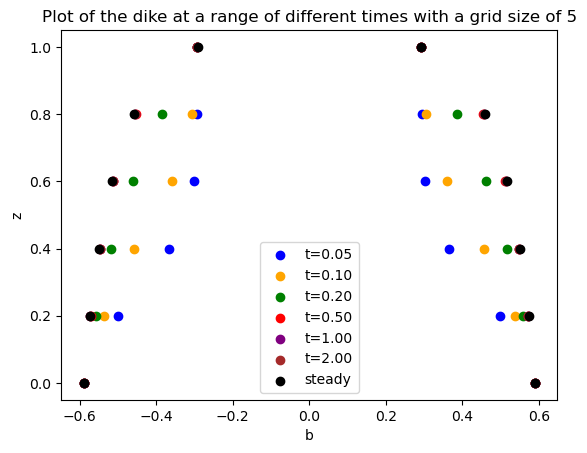

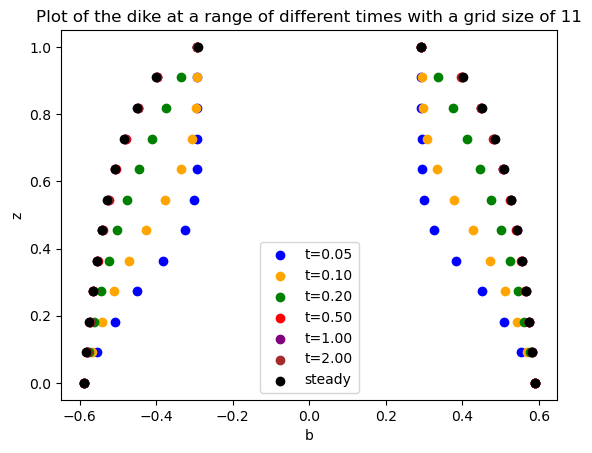

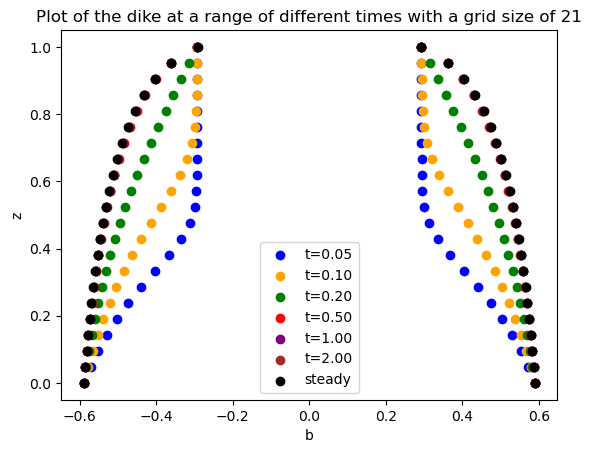

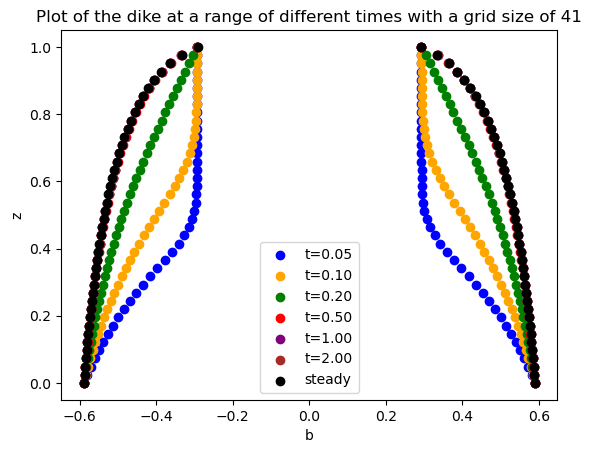

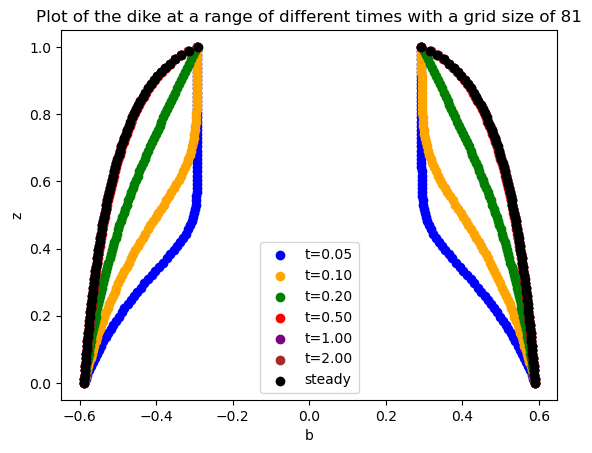

In [ ]:
# Colours for each time 
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'black']

# Plot the dimension plots for the different grid sizes 
for grid, df in extracted_solutions:
    title = f'Plot of the dike at a range of different times with a grid size of {grid}'
    time_scatter = [times] * 2  # Each time has a positive and negative scatter]
    
    for time in range(1, len(df.columns)):
        current_time = df.columns[time]
        current_color = colors[time - 1]
        plt.scatter(df[df.columns[time]].values / 2, df['z'], label=f'{df.columns[time]}', color=current_color)
        plt.scatter(-df[df.columns[time]].values / 2, df['z'], color=current_color)

    plt.xlabel('b')
    plt.ylabel('z')
    plt.title(title)
    plt.legend()
    plt.show()


### 2c): $L^2$ Norm

Considering the steady state solution to be exact for large times ($t>2$), we calculate error function defined
$$e(z,t) = b(z,t) - b_{numerical}(z,t)$$
where $b(z,t)$ is taken to be the steady state solution.


In [72]:
def trapezoidal_integration(x: list[float], y: list[float]) -> float:
    # Perform composite trapezoidal integration of y with respect to x
    integral = 0.0
    for i in range(1, len(x)):
        integral += (x[i] - x[i-1]) * (y[i] + y[i-1]) / 2
    return integral

def downsize(data: list[float], new_size: int) -> list[float]:
    # Downsize the resolution of the data assuming even spacing and equal limits
    factor = len(data) // (new_size - 1)
    indices = [i * factor for i in range(new_size)]
    print(f'Downsize indices: {indices}')
    return [data[i * factor] for i in range(new_size)]

# A class to hold the numerical solutions and any further methods that need to be applied to them
class NumericalSolution(object):
    def __init__(self, z_values: list[float], time_values: list[float], b_values: list[list[float]], 
                 verbosity = 0):
        self.z_values = z_values
        self.time_values = time_values
        self.b_values = b_values

        self.grid_size = len(z_values)
        
        self.verbosity = verbosity

    def get_time_range(self) -> tuple[float, float]:
        # Return the time range of the solution
        return self.time_values[0], self.time_values[-1]
    
    def get_grid_spacing(self) -> float:
        # Return the grid spacing of the solution
        return self.z_values[1] - self.z_values[0]
    
    def plot_solution(self, title: str = 'Dimension plot of the dike at various times'):
        # Plot the solution as 5 different time points weighted towards t=0
        spacing = [0.05, 0.1, 0.2, 0.4, 0.8]
        time_indices = [int(s * len(self.time_values)) for s in spacing]

        # Five different colors
        colors = ['blue', 'orange', 'green', 'red', 'purple']

        z = self.z_values
        for time in time_indices:
            # Extract data
            b = self.b_values[time]
            # Take half values
            b_half = [val / 2 for val in b]
            neg_b_half = [-val / 2 for val in b]
            plt.plot(b_half, z, label=f't={self.time_values[time]:.2f}', 
                     color=colors[time_indices.index(time)])
            plt.plot(neg_b_half, z, color=colors[time_indices.index(time)])
        plt.xlabel('b')
        plt.ylabel('z')
        plt.title(title)
        plt.legend()
        plt.show()

    def steady(self) -> list[float]:
        # Return the presumed steady state solution at large time
        return self.b_values[-1]
    
    def difference(self, comparative: list[float]) -> list[float]:
        # Return the difference between the computed and comparative solutions
        return [c - s for c, s in zip(comparative, self.steady())]
    
    def l2_norm(self, comparative: list[float]) -> float:
        # Return the L2 norm of the difference between the computed and comparative solutions
        diff = self.difference(downsize(comparative, self.grid_size))

        squared_diffs = [d**2 for d in diff]
        if self.verbosity > 0:
            # Plot the differences
            plt.plot(self.z_values, squared_diffs, label='Difference')
            plt.xlabel('z')
            plt.ylabel('Difference')
            plt.title('Difference between computed and comparative solutions')
            plt.legend()
            plt.show()
        integral = trapezoidal_integration(self.z_values, squared_diffs)

        if self.verbosity > 0:
            print(f'Integral Evaluation: {integral}')
        self.l2_norm_value = np.sqrt(integral)
        return self.l2_norm_value

    def exact_residual(self, alpha: float) -> list[list[float]]:
        # Compute zr0 given the initial condition b(0,0) = bT
        bT = self.b_values[0][0]
        zr0 = 1/alpha * (bT - np.arctanh(bT))

        def residual(b, z, t):
            # Domain of arctanh is [-1,1]
            if abs(b) > 1:
                return np.nan
            return z - zr0 - t - 1/alpha * (b - np.arctanh(b))
        
        residuals: list[list[float]] = []
        for n in range(len(self.time_values)):
            t = self.time_values[n]
            res_n: list[float] = []
            for j in range(len(self.z_values)):
                z = self.z_values[j]
                b = self.b_values[n][j]
                res_n.append(residual(b, z, t))
            residuals.append(res_n)

        if self.verbosity > 0:
            # Plot heatmap 
            self.plot_heatmap(residuals)
        return residuals

    def plot_heatmap(self, residuals):
        plt.figure(figsize=(10, 6))
        plt.imshow(residuals, aspect='auto', origin='lower', cmap='viridis',
                       extent=[self.z_values[0], self.z_values[-1], 
                               self.time_values[0], self.time_values[-1]],
                       vmin=0, vmax=1)
        plt.colorbar(label='Residual')
        plt.xlabel('z')
        plt.ylabel('t')
        plt.title('Residual Heatmap')
        plt.show()

        

In [73]:
# Create NumericalSolution objects for each grid size
numerical_solutions: dict[str, NumericalSolution] = {}
for grid, z_vals, t_vals, b_vals in solutions:
    numerical_solutions[grid] = NumericalSolution(z_vals, t_vals, b_vals)


Downsize indices: [0, 2000, 4000, 6000, 8000, 10000]
Downsize indices: [0, 909, 1818, 2727, 3636, 4545, 5454, 6363, 7272, 8181, 9090, 9999]
Downsize indices: [0, 476, 952, 1428, 1904, 2380, 2856, 3332, 3808, 4284, 4760, 5236, 5712, 6188, 6664, 7140, 7616, 8092, 8568, 9044, 9520, 9996]
Downsize indices: [0, 243, 486, 729, 972, 1215, 1458, 1701, 1944, 2187, 2430, 2673, 2916, 3159, 3402, 3645, 3888, 4131, 4374, 4617, 4860, 5103, 5346, 5589, 5832, 6075, 6318, 6561, 6804, 7047, 7290, 7533, 7776, 8019, 8262, 8505, 8748, 8991, 9234, 9477, 9720, 9963]
Downsize indices: [0, 123, 246, 369, 492, 615, 738, 861, 984, 1107, 1230, 1353, 1476, 1599, 1722, 1845, 1968, 2091, 2214, 2337, 2460, 2583, 2706, 2829, 2952, 3075, 3198, 3321, 3444, 3567, 3690, 3813, 3936, 4059, 4182, 4305, 4428, 4551, 4674, 4797, 4920, 5043, 5166, 5289, 5412, 5535, 5658, 5781, 5904, 6027, 6150, 6273, 6396, 6519, 6642, 6765, 6888, 7011, 7134, 7257, 7380, 7503, 7626, 7749, 7872, 7995, 8118, 8241, 8364, 8487, 8610, 8733, 8856, 8979

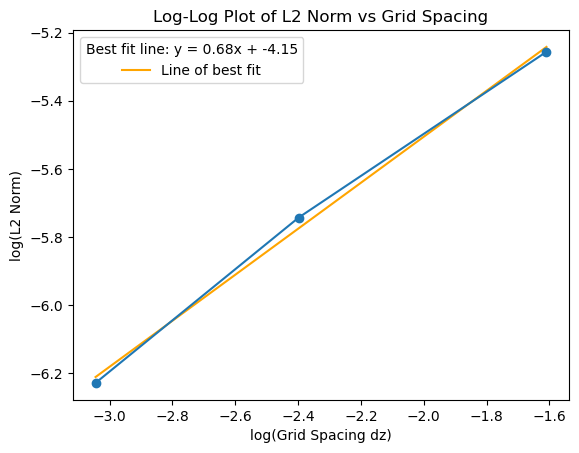

In [75]:
def plot_l2_norm(numerical_solutions: dict[str, NumericalSolution]):
    # Comparing the L2 Norm and the grid spacing dz
    grid_spacings = []
    l2_norms = []
    for grid, solution in numerical_solutions.items():
        dz = solution.get_grid_spacing()
        grid_spacings.append(dz)
        l2_norms.append(solution.l2_norm(steady_solution['b']))

    log_grid_spacings = np.log(grid_spacings)[:-2]
    log_l2_norms = np.log(l2_norms)[:-2]

    # Line of best fit
    coeffs = np.polyfit(log_grid_spacings, log_l2_norms, 1)
    print(f'Line of best fit: y = {coeffs[0]}x + {coeffs[1]}')
    poly = np.poly1d(coeffs)
    fit_values = poly(log_grid_spacings)
    plt.plot(log_grid_spacings, fit_values, label='Line of best fit', color='orange')



    plt.plot(log_grid_spacings, log_l2_norms, marker='o')
    plt.xlabel('log(Grid Spacing dz)')
    plt.ylabel('log(L2 Norm)')
    plt.title('Log-Log Plot of L2 Norm vs Grid Spacing')
    # Legend with equation of line of best fit
    plt.legend(title=f'Best fit line: y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}')

    plt.show()

plot_l2_norm(numerical_solutions)


From this plot we see that the order of the spatial discretisation, that is the relationship between accuracy and $\Delta z$ grid spacing, is approximately $0.68$.

# 2d): Exact Solution
Given the exact solution
$$z - z_{r0} - ct = \frac{\beta}{\alpha}\left(b(z,t) - \sqrt{c/\alpha}\;\text{atanh}\left[\sqrt{(c/\alpha)}b(z,t)\right]\right)$$
we consider the residuals when the numerical solution is given as $b$. Note that we have $\alpha = c$ and $\beta = 1$ and so have further reduction
$$z - z_{r0} - ct = \frac{1}{\alpha}(b(z,t) - \text{atanh}(b(z,t)))$$


In [76]:
# Define the new initial and boundary conditions based on the exact solution.
def initial_condition(z, alpha = 0.4709):
    if z > 0.3:
        return 0
    else:
        return ((3 * alpha) * (0.3 - z)) ** (1/3)
    
def bottom_boundary(t, alpha = 0.4709):
    return (3 * alpha ** 2 * (t + (0.3 / alpha))) ** (1/3)

def top_boundary(t, alpha = 0.4709):
    if t < 0.7 / alpha:
        return 0
    else:
        return (3 * alpha ** 2 * (t - (0.7 / alpha))) ** (1/3)
    
    

Computation of the exact solution used to determine the initial and boundary conditions. Plots show the process at various stages ending with the "inverted" function $b(z,t)$ and the initial $b(z,0)$.

/tmp/ipykernel_692301/3938898181.py:7: RuntimeWarning: divide by zero encountered in arctanh
  right = (1/alpha) * (b_values[b] - np.arctanh(b_values[b]))


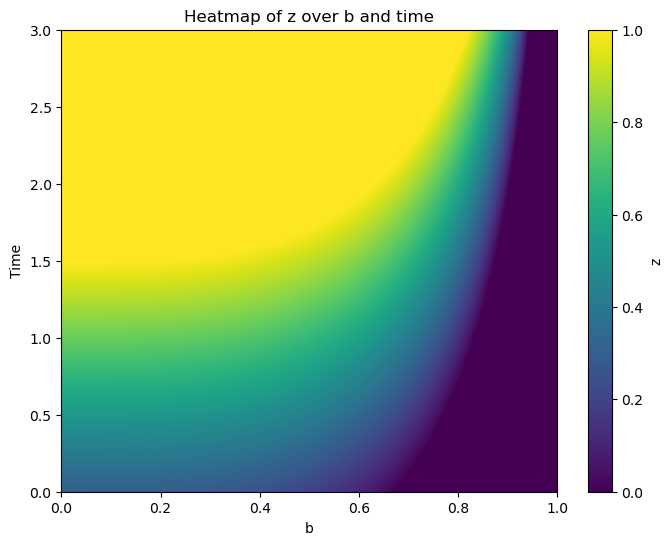

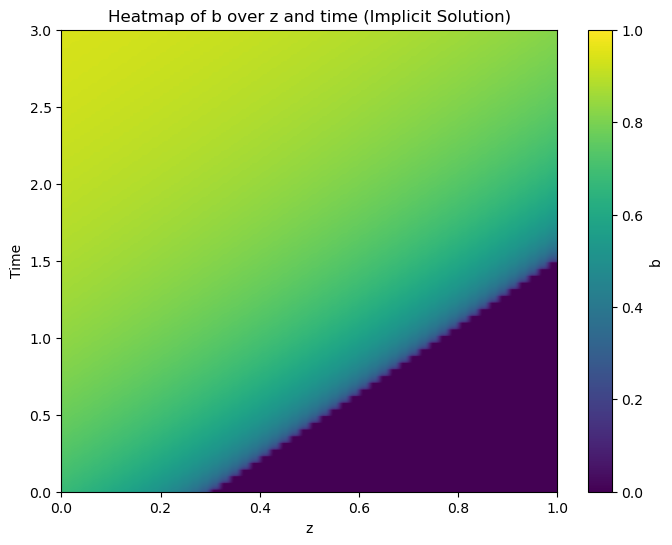

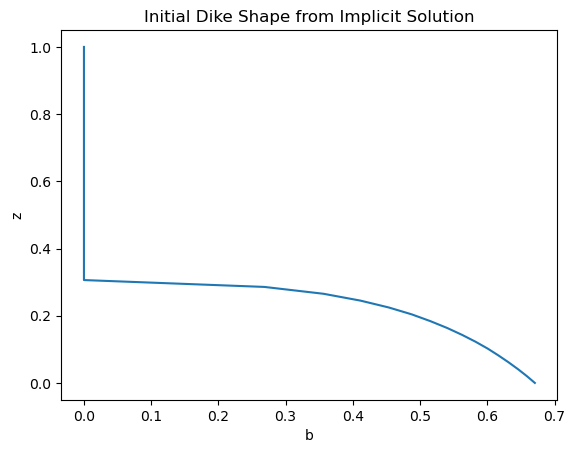

In [77]:
# Implicit calculation of z values from b and t values
t_values = np.linspace(0, 3, 1000)
b_values = np.linspace(0, 1, 1000)
z_values = np.zeros((len(t_values), len(b_values)))
for t in range(len(t_values)):
    for b in range(len(b_values)):
        right = (1/alpha) * (b_values[b] - np.arctanh(b_values[b]))
        left = 0.3 + alpha * t_values[t]
        z_values[t, b] = left + right

# Plot the z values as a heatmap with the x-axis being b and the y-axis being time
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    z_values,
    aspect='auto',
    cmap='viridis',
    origin='lower',
    extent=(b_values[0], b_values[-1], t_values[0], t_values[-1]),
    vmin=0, vmax=1  # Set the colour scale for z values
)
ax.set_title('Heatmap of z over b and time')
ax.set_xlabel('b')
ax.set_ylabel('Time')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('z')
plt.show()

z_targets = np.linspace(0,1, 50)
b_results = np.zeros((len(t_values), len(z_targets)))

for t in range(len(t_values)):
    for zt in range(len(z_targets)):
        # Find index of closest z value in z_values[t]
        z_index = np.abs(z_values[t] - z_targets[zt]).argmin()

        b_results[t, zt] = b_values[z_index]

# Plot the b results as a heatmap with the x-axis being z and the y-axis being time
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(
    b_results,
    aspect='auto',
    cmap='viridis',
    origin='lower',
    extent=(z_targets[0], z_targets[-1], 
            t_values[0], t_values[-1]),
    vmin=0, vmax=1  # Set the colour scale for b values
)
ax.set_title('Heatmap of b over z and time (Implicit Solution)')
ax.set_xlabel('z')
ax.set_ylabel('Time')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('b')
plt.show()

# Extract b values at t = 0 and plot
b_t0 = b_results[0, :]
plt.plot(b_t0, z_targets)
plt.xlabel('b')
plt.ylabel('z')
plt.title('Initial Dike Shape from Implicit Solution')
plt.show()

exact = NumericalSolution(z_targets.tolist(), t_values.tolist(), b_results.tolist())

In [78]:
def initial_condition_2(z, data: list[float]):
    # Data is an evenly spaced array of z values between 0 and 1, we assume at high enough
    # resolution that linear interpolation is not necessary
    if z <= 0 or z >= 1:
        return -1
    index = int(z * (len(data) - 1))
    return data[index]

def bottom_boundary_2(t, data: list[float]):
    # Data is an evenly spaced array of t values between 0 and 3, we assume at high enough
    # resolution that linear interpolation is not necessary
    if t < 0 or t >= 3:
        return -1
    index = int(t * (len(data) - 1) / 3)
    return data[index]

def top_boundary_2(t, data: list[float]):
    # Data is an evenly spaced array of t values between 0 and 3, we assume at high enough
    # resolution that linear interpolation is not necessary
    if t < 0 or t >= 3:
        return -1
    index = int(t * (len(data) - 1) / 3)
    return data[index]


Time Dependent solver with varying initial and boundary conditions.

In [79]:
from typing import Callable

def time_dependent_solve_varying_boundary(alpha: float, beta: float, H: float, 
                         J: int, dt: float, bB: list[float], 
                         bT: list[float], initial: list[float] = None, 
                         max_time: float = 3, verbosity = 0) -> NumericalSolution:
    
    # Initialise the starting values
    dz = H / J
    print(f'dz: {dz}')

    # Calculate the upper bound on dt for stability
    time_step_limit(alpha, beta, bB[0], dt, dz)

    # Check that the sizes of initial and boundaries are correct
    if initial is not None and len(initial) != J + 1:
        raise ValueError(f'Initial condition size {len(initial)} does not match grid size {J + 1}')
    if len(bB) != int(max_time / dt):
        raise ValueError(f'Bottom boundary size {len(bB)} does not match time steps {int(max_time / dt)}')
    if len(bT) != int(max_time / dt):
        raise ValueError(f'Top boundary size {len(bT)} does not match time steps {int(max_time / dt)}')

    z_values: list[float] = [j * dz for j in range(J + 1)]
    b_values: list[list[float]] = [initial]  # Initial condition: b(z, 0) = initial_condition for all z, t in the first index, z in the second index
    time_values: list[float] = [0.0]

    time_steps = int(max_time / dt)
    print(f'Time steps: {time_steps}')
    for time_step in range(time_steps):
        t = (time_step + 1) * dt
        # Initialize the next time step array with boundary condition
        b_next: list[float] = [bB[time_step]] + [0.0 for _ in range(1, J)] + [bT[time_step]]
        for j in range(1, J):
            b_next[j] = time_iteration(b_values[-1][j-1:j+2], alpha, bB[time_step], beta, dz, dt)
        b_values.append(b_next)
        time_values.append(t)

    return NumericalSolution(z_values, time_values, b_values, verbosity)

dz: 0.047619047619047616
Stable dt: 0.0035789131577399088, Given dt: 1e-05
Time steps: 300000


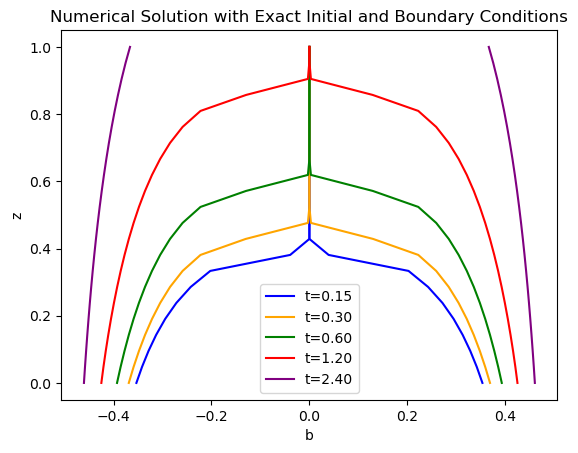

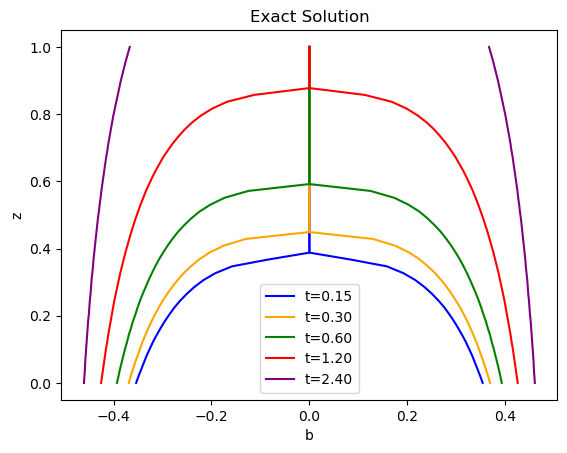

In [80]:
grid_size = 21
time_step = 1e-5
max_time = 3

initial_data = [initial_condition_2(z, b_t0) for z in np.linspace(0,1, grid_size + 1)]
bB_data = [bottom_boundary_2(t, b_results[:,0]) for t in np.linspace(0,3, int(max_time / time_step))]
bT_data = [top_boundary_2(t, b_results[:,-1]) for t in np.linspace(0,3, int(max_time / time_step))]

sol = time_dependent_solve_varying_boundary(alpha, beta, H, grid_size, time_step, bB_data, 
                                            bT_data, initial_data, max_time, 0)

sol.plot_solution(title='Numerical Solution with Exact Initial and Boundary Conditions')
exact.plot_solution(title='Exact Solution')

We verify the numerical solution by computing residuals with the exact solution through time.

In [81]:

def residual_calc(b, alpha, z, t):
    if abs(b) > 1:
        return np.nan
    return z - 0.3 - alpha*t + (1/alpha) * (b - np.arctanh(b))

# Create a table of b, z and t values

data = {'z': [], 't': [], 'b': [], 'residual': []}
for n in range(len(sol.time_values)):
    t = sol.time_values[n]
    for j in range(len(sol.z_values)):
        z = sol.z_values[j]
        b = sol.b_values[n][j]
        res = residual_calc(b, alpha, z, t)

        data['z'].append(z)
        data['t'].append(t)
        data['b'].append(b)
        data['residual'].append(res)

        if j == int(len(sol.z_values) / 2) and n == int(len(sol.time_values) / 2):
            print(f'At z = {z}, t = {t}, b = {b}, residual = {res}')



/tmp/ipykernel_692301/2740824825.py:4: RuntimeWarning: divide by zero encountered in arctanh
  return z - 0.3 - alpha*t + (1/alpha) * (b - np.arctanh(b))


At z = 0.5238095238095237, t = 1.5000000000000002, b = 0.7548443295083486, residual = -0.9694308704167303


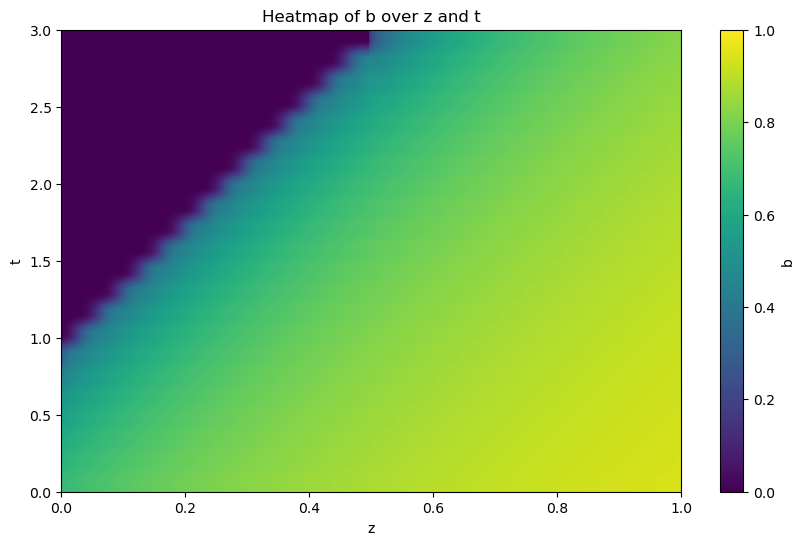

/tmp/ipykernel_692301/2740824825.py:4: RuntimeWarning: divide by zero encountered in arctanh
  return z - 0.3 - alpha*t + (1/alpha) * (b - np.arctanh(b))


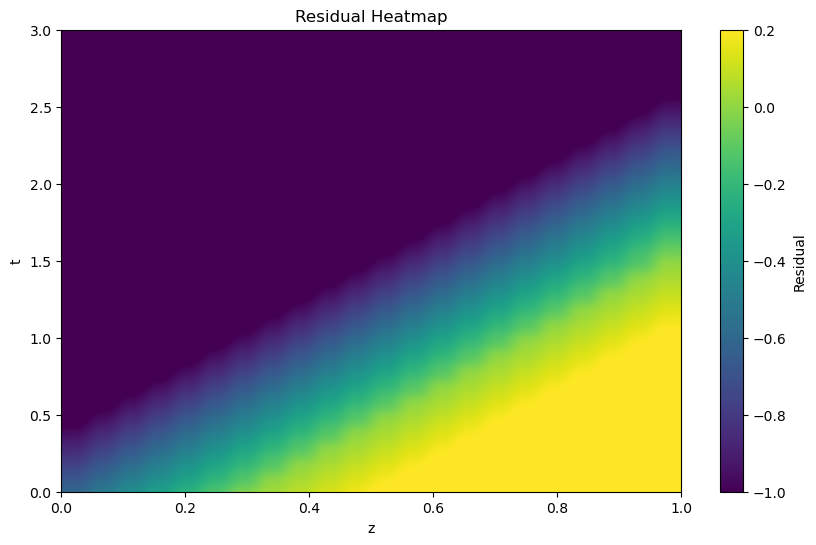

In [82]:
# Plot a heat map with z on the x axis, t on the y axis and b as the color using imshow
plt.figure(figsize=(10, 6))
plt.imshow(np.array(sol.b_values).T, aspect='auto', origin='lower', cmap='viridis',
               extent=[sol.z_values[0], sol.z_values[-1], 
                       sol.time_values[0], sol.time_values[-1]],
               vmin=0, vmax=1)
plt.colorbar(label='b')
plt.xlabel('z')
plt.ylabel('t')
plt.title('Heatmap of b over z and t')
plt.show()

# Plot heatmap with b replaced by residual
plt.figure(figsize=(10, 6))
residuals = [[residual_calc(sol.b_values[n][j], alpha, sol.z_values[j], sol.time_values[n]) 
              for j in range(len(sol.z_values))] for n in range(len(sol.time_values))]
plt.imshow(residuals, aspect='auto', origin='lower', cmap='viridis',
               extent=[sol.z_values[0], sol.z_values[-1], 
                       sol.time_values[0], sol.time_values[-1]],
               vmin=-1, vmax=0.2)
plt.colorbar(label='Residual')
plt.xlabel('z')
plt.ylabel('t')
plt.title('Residual Heatmap')
plt.show()

The residual heatmap here shows the difference between the numerical solution and the exact solution at points within the domain.